In [1]:
# Import a number is useful packages...
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
from mpl_toolkits.mplot3d import Axes3D
from STUFF.poisson_disc import Grid
import seaborn as sns
import random 

# CH273: Computational Workshop 1
## The Lennard-Jones Potential


In this session, we are going to play around with the Lennard-Jones potential ($U_{LJ}$), that is:

$$
U_{LJ}(r) = 4\epsilon \left [ \left ( \frac{\sigma}{r} \right )^{12} - \left ( \frac{\sigma}{r} \right )^{6} \right ]
$$

where $\epsilon$ is the depth of the potential well, $\sigma$ is the distance at which $U_{LJ}$ is zero (that is, the "size" of the particle) and $r$ is the distance between a given pair of particles (or atoms, or molecules, etc.). Let's start by assigning some values to $\epsilon$ (in eV) and  $\sigma$ (in Å). Fun fact: many computational people deal with LJ systems via a set of "reduced" units, which are really convenient (because they are based on $\epsilon$ and $\sigma$) but also quite confusing at first. If you are interested, check out [this page](https://cms.sjtu.edu.cn/gs/doc/MD2019/LJ.pdf).

In [2]:
epsilon = 0.12 # eV
sigma = 0.5 # Å

# Let's generate some distances r, from 0.01 Å up to max_r = 10 Å
max_r = 10 # Å
r = np.arange(1e-2,max_r,1e-2)

# As "r" is a numpy array, we can manipulate ALL the distances at the same time to obtain U_LJ in one go
#IHaveGotThePowa
U_r = 4 * epsilon * ( (sigma/r)**12 - (sigma/r)**6 )

Let's have a look...

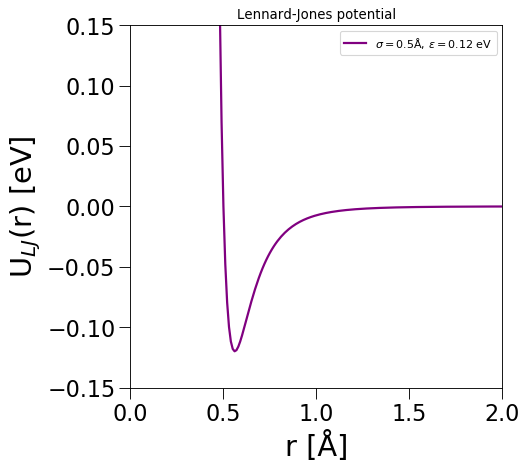

In [3]:
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(r, U_r, color='purple', linestyle='solid', linewidth=2.0, label="$\sigma=0.5$\305, $\epsilon=0.12$ eV")
plt.xlim(0,2)
plt.ylim(-0.15,0.15)
plt.title("Lennard-Jones potential")
plt.xlabel("r [\305]", fontsize=26)
plt.ylabel("U$_{LJ}$(r) [eV]", fontsize=26)
plt.rcParams["figure.figsize"] = (8,8)
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)
plt.legend()
plt.show()

Note that for $r$ greater than ~1.5 Å, our potential is basically zero. If we were to choose, e.g., $\sigma$ = 1.5 Å, however...

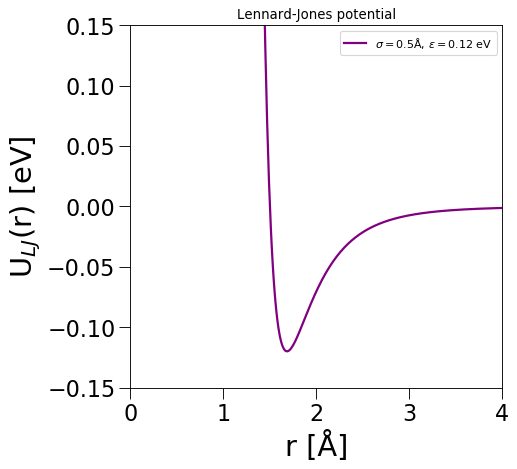

In [4]:
sigma = 1.5 # Å
U_r = 4 * epsilon * ( (sigma/r)**12 - (sigma/r)**6 )

plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(r, U_r, color='purple', linestyle='solid', linewidth=2.0, label="$\sigma=0.5$\305, $\epsilon=0.12$ eV")
plt.xlim(0,4)
plt.ylim(-0.15,0.15)
plt.title("Lennard-Jones potential")
plt.xlabel("r [\305]", fontsize=26)
plt.ylabel("U$_{LJ}$(r) [eV]", fontsize=26)
plt.rcParams["figure.figsize"] = (8,8)
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)
plt.legend()
plt.show()

Ok, let's get back to $\sigma$ = 0.5 Å...

In [5]:
sigma = 0.5
U_r = 4 * epsilon * ( (sigma/r)**12 - (sigma/r)**6 )

### Computing the LJ energy of a 2D system of randomly distributed particles

Now that we have an idea of what the LJ potential looks like, let's try to compute the LJ energy of a two-dimensional system of randomly distributed particles. To this end, we are going to leverage the so-called "Poisson-disc sampling", which is a very convenient (and rather cool I might add...) way to generate different random configurations quickly enough. If you are interested about the details of this algorithm, check out [this page](https://www.jasondavies.com/poisson-disc/). In order to generate a configuration we need to know two things: (1) the length of the (square, let's keep this simple) 2D box and; (2) the minimum distance allowed between the particles. The algorithm generates a certain number $N$ (which might vary!) of particles. Practically speaking, you get two arrays (both of size $N$) containing the x and y positions of each particle.

In [6]:
# Set the length and width (the x and y dimensions) of the box
length = 10.0 # Å
width = length # This is a square 2D box

# Set the minimum distance between the particles
min_r = 0.6 # Å 

# Generate a random arrangement of particles - according to an algorithm called Poisson sampling.
# Note that every time you run this cell, the algorithm will generate a DIFFERENT configuration!
grid = Grid(min_r, length, width)

# Random seed 
rand = (random.uniform(0, length), random.uniform(0, width))

# Do the sampling
data = np.array(grid.poisson(rand))
pos_x=np.array(data[:,0])
pos_y=np.array(data[:,1])

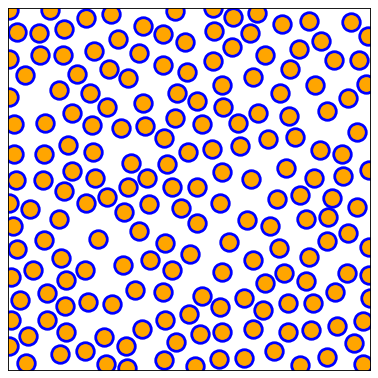

In [7]:
# Let's visualize the box and the particles - i.e. our hard sphere-ish liquid
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(pos_x,pos_y,s=250, facecolors='orange', edgecolors='blue',linewidth=2.5)
plt.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
plt.xlim(0,length)
plt.ylim(0,length)
plt.gca().set_aspect('equal', adjustable='box')
plt.rcParams["figure.figsize"] = (8,8)
plt.show()

Neat! Now, let's compute the LJ energy of this particular configuration. Our LJ potential is:

$$
U_{LJ}(r) = 4\epsilon \left [ \left ( \frac{\sigma}{r} \right )^{12} - \left ( \frac{\sigma}{r} \right )^{6} \right ]
$$

In our case, however, we need to sum over ALL the pairs of particles we have in the box! That is:

$$
U_{LJ}(r) = 4\epsilon \sum_{i=1}^{N} \sum_{j=1,\ne i}^{N}\left [ \left ( \frac{\sigma}{r_{ij}} \right )^{12} - \left ( \frac{\sigma}{r_{ij}} \right )^{6} \right ]
$$

If we do this, though, we will be double counting, because we will be considering, e.g. $r_{1,2}$ as well as $r_{2,1}$. To avoid this, we can start the second summation from $i$ as opposed to 1. That is:

$$
U_{LJ}(r) = 4\epsilon \sum_{i=1}^{N} \sum_{j=i+1}^{N}\left [ \left ( \frac{\sigma}{r_{ij}} \right )^{12} - \left ( \frac{\sigma}{r_{ij}} \right )^{6} \right ]
$$

In this way we avoid double counting (and we also remove the need to check for the $i=j$ case). In addition, we are also going to choose a "cutoff radius", that is a maximum distance above which we do not bother to calculate our LJ energy. Why? well, for one thing we know that for $r$ greater than ~ 1.5 Å our LJ potential is basically zero. In fact, if we were to do things "properly" (check out [this page](https://hoomd-blue.readthedocs.io/en/stable/nlist.html) if interested!), we could save quite a lot of computer time by doing this. Most importantly, though, by choosing a cutoff radius smaller than half of the box length we will avoid the need of taking into account [periodic boundary conditions](https://en.wikipedia.org/wiki/Periodic_boundary_conditions) (PBC).

In [8]:
# As the number of atoms / configuration will change every time to run the Poisson-disc sampling,
# we need to make sure we get this right every time
n_atoms = len(pos_x)

E_lj = 0.0 # Initialise
r_cut = 2.0 # Less than length/2, otherwise: PBC!
for i in range (0,n_atoms):
    for j in range (i+1,n_atoms):
        
        # Compute the distance between each pair of atoms
        d_ij = np.sqrt((pos_x[j]-pos_x[i])**2 + (pos_y[j]-pos_y[i])**2)
        
        # Check whether this distance is shorter than the cutoff radius
        if d_ij <= r_cut:
            
            # Add this contribution to our LJ energy
            E_lj = E_lj + (4 * epsilon * ( (sigma/d_ij)**12 - (sigma/d_ij)**6 ) )
            
print("The LJ energy for this configuration is:", E_lj,"eV")

The LJ energy for this configuration is: -20.481476003467794 eV


This is a *negative* value, which means that our system is quite happy to be in that particular configuration. Positive values of the energy indicate that the system is very very unhappy to be there instead.

### LJ energy as a function of the minimum distance between the particles
If we were to modify the minimum distance between the particles, we will end up in regions of the LJ potential where the LJ energy is either impossibly high (i.e. $r << \sigma$) or factually zero (i.e. $r >> \sigma$). Let's try to study the dependence of the LJ energy as a function of this minimum distance, then. Because we are lazy (in a good, computationally sensible way), we will write down a function to generate a random configuration of the system (given a certain minimum distance between the particles) as well as a function to compute the LJ energy of a given configuration (given the atomic positions as well as the cutoff radius).

In [9]:
# This function generates a configuration of the system for a given box length (l) 
# and a given minimum distance between the particles (mr)
def gen_conf(l,mr):
    w = l
    grid = Grid(mr, l, w)
    rand = (random.uniform(0,l), random.uniform(0,w))
    data = np.array(grid.poisson(rand))
    pos_x=np.array(data[:,0])
    pos_y=np.array(data[:,1])
    return(pos_x,pos_y)

In [10]:
# This function compute the LJ energy for a given configuration, given the atomic positions (px,py)
# and a given cutoff radius

def lj_conf(px,py,rc):
    n_atoms = len(px)
    E_lj = 0.0
    for i in range (0,n_atoms):
        for j in range (i+1,n_atoms):
            d_ij = np.sqrt((px[j]-px[i])**2 + (py[j]-py[i])**2)
            if d_ij <= rc:
                E_lj = E_lj + (4 * epsilon * ( (sigma/d_ij)**12 - (sigma/d_ij)**6 ) )
    return(E_lj)

In [11]:
# Let compute the LJ energy for ten different values of the minimum distance between the particles,
# from 0.4 to 2 Å

# Note: this might take a little while!
sep = np.linspace(0.4,2,50)
elj = []
for i in sep:
    pos_x,pos_y = gen_conf(length,i)
    elj.append(lj_conf(pos_x,pos_y,r_cut))

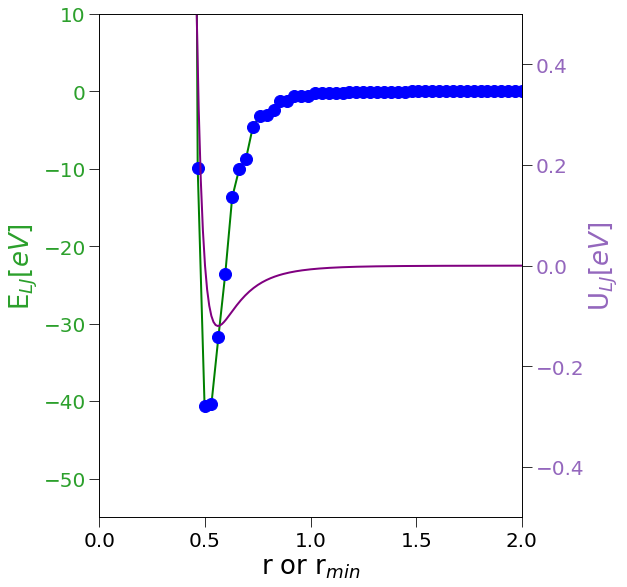

In [12]:
# Let's have a look, shall we?
fig, ax1 = plt.subplots()
color = 'tab:green'
ax1.plot(sep, elj, color='green', linestyle='solid', linewidth=2.0)
ax1.plot(sep, elj, 'o', color='blue', markersize=12)
ax1.set_xlabel("r or r$_{min}$", fontsize=26)
ax1.set_ylabel("E$_{LJ} [eV]$", fontsize=26, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(0,2)
ax1.set_ylim(-55,10)

ax2 = ax1.twinx()
color = 'tab:purple'
ax2.plot(r, U_r, color='purple', linestyle='solid', linewidth=2.0, label="$\sigma=0.5$\305, $\epsilon=0.12$ eV")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-0.5,0.5)
ax2.set_ylabel("U$_{LJ} [eV]$", fontsize=26, color=color)
fig.tight_layout()

# plt.rcParams["figure.figsize"] = (8,8)
ax1.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)
ax2.tick_params(direction="out", length=10.0, labelbottom=True, labelsize=20.0)
# plt.legend()
plt.show()

<div class="alert alert-block alert-info">
    
<h2>Task 1</h2>

Calculate the ensemble average (assuming we are working in the microcanonical ensemble NVE) of the LJ energy of our system (with $r_{min}$=0.6). How many configurations do you need to achieve a sensible result? Can you quantify the uncertainty associated with your estimate?
<div/>

As a first guess, we can plot the value of the ensemble average as a function of the number of configurations we have considered

In [13]:
nc = 50 # just a starting guess...

l = 10
mr = 0.6

e_ave = []

for i in range (1,nc):
    px,py = gen_conf(l,mr)
    e_ave.append(lj_conf(px,py,r_cut))

In [14]:
ra = 0.0
c = 0
rra = []
for i in e_ave:
    c = c+1
    ra = ra + i
    rra.append(ra/c)

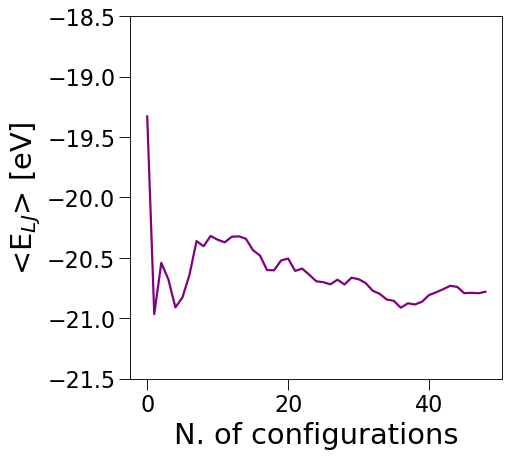

In [15]:
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rra, color='purple', linestyle='solid', linewidth=2.0)
# plt.xlim(0,4)
plt.ylim(-21.5,-18.5)
plt.xlabel("N. of configurations", fontsize=26)
plt.ylabel("<E$_{LJ}$> [eV]", fontsize=26)
plt.rcParams["figure.figsize"] = (8,8)
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)
plt.show()

Using numpy, we can also compute the average and the standard deviation of each of these averages

In [17]:
un = np.zeros((len(e_ave),3))
for i in range (1,len(e_ave)):
    un[i,0] = i
    un[i,1] = np.average(e_ave[:i])
    un[i,2] = np.std(e_ave[:i])

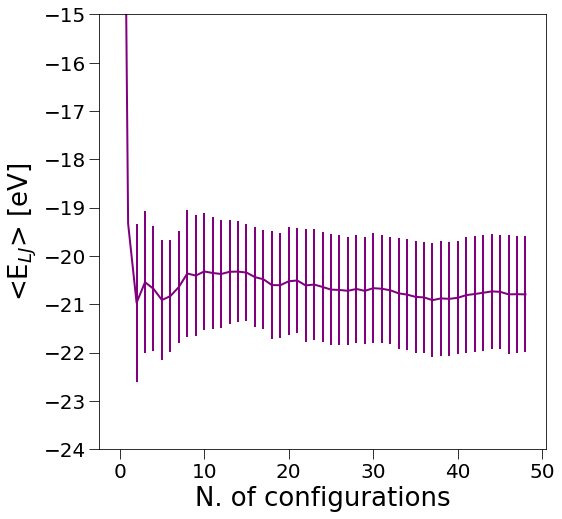

In [18]:
# plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.errorbar(un[:,0], un[:,1], yerr=un[:,2], color='purple', linestyle='solid', linewidth=2.0)
# plt.xlim(0,4)
plt.ylim(-24,-15)
plt.xlabel("N. of configurations", fontsize=26)
plt.ylabel("<E$_{LJ}$> [eV]", fontsize=26)
plt.rcParams["figure.figsize"] = (8,8)
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)
plt.show()

Still rather large error bars!